In [334]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
data = pd.read_csv("tsp.csv", index_col=0)
data.x = data.x.astype(int)
data.y = data.y.astype(int)

In [702]:
def dist(d):
    return sum(np.abs(np.diff(d.x)) + np.abs(np.diff(d.y)))

In [703]:
def plotData(df):
    repeated = pd.DataFrame(np.repeat(df.x,2))
    repeated["y"] = np.repeat(df.y,2).shift(1).fillna(0).astype("int")
    repeated = repeated.iloc[1:]
    plt.figure(figsize=(10,10))
    plt.plot(repeated.x, repeated.y, 'r', lw=1)
    plt.scatter(data.x, data.y, s=80)
    plt.title('Lines on top of dots')

In [707]:
def mcRandomSamplingOpt(data, itercount = 10000):
    min_dist = dist(data)
    cur_data = list(data.index.values)
    best_data = cur_data
    for i in range(0,itercount):
        cur_data = np.random.permutation(data.index.values)
        sampled_data = data.loc[cur_data]
        cdist = dist(sampled_data)
        if(cdist < min_dist):
            min_dist = cdist
            best_data = cur_data
    print("Distance: ", min_dist)
    return best_data

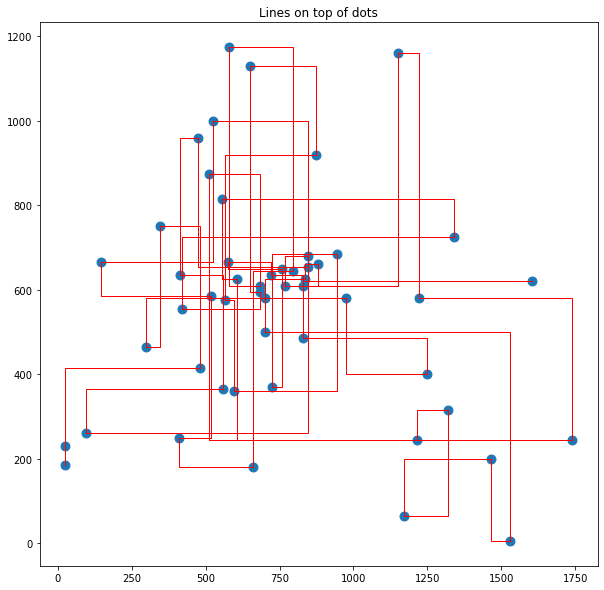

In [708]:
mc_data = mcRandomSamplingOpt(data, 100000)
plotData(data.loc[mc_data])

In [709]:
def Mutate(old_state):
    new_state = old_state.copy()
    dlen = len(new_state)
    rand1 = random.randint(0, dlen - 1)
    rand2 = random.randint(0, dlen - 1)
    new_state[rand1], new_state[rand2] = new_state[rand2], new_state[rand1]
    return new_state


In [712]:
def randomWalkOpt(data, itercount = 100000):
    min_dist = dist(data)
    cur_data = data.index.values.copy()
    best_data = cur_data.copy()
    dlen = len(cur_data)
    for i in range(0,itercount):
        cur_data = Mutate(cur_data)
        cdist = dist(data.loc[cur_data])
        if(cdist < min_dist):
            min_dist = cdist
            best_data = cur_data.copy()
    print("Distance:", min_dist)
    return best_data


In [711]:
rw_inds = randomWalkOpt(data)

27545
25815


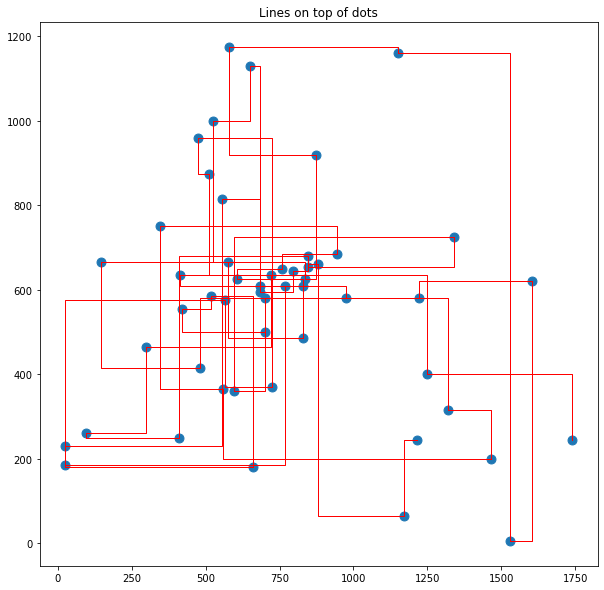

In [301]:
plotData(data.loc[rw_inds])

In [356]:
def hillClimbOpt(data, itercount = 50000):
    min_dist = dist(data)
    cur_data = data.index.values
    best_data = cur_data.copy()
    dlen = len(cur_data)
    swaps = [(i,j) for i in range(0, dlen - 1) for j in range(i, dlen -1)]

    for i in range(0,itercount//len(swaps)):
        print(f"{i/itercount*len(swaps)*100}%")
        for m,n in swaps:
            cur_data = best_data.copy()
            cur_data[m], cur_data[n] = cur_data[n], cur_data[m]
            cdist = dist(data.loc[cur_data])

            if(cdist < min_dist):
                min_dist = cdist
                best_data = cur_data.copy()
    return best_data

0.0%
2.652%
5.304%
7.956%
10.608%
13.26%
15.912%
18.563999999999997%
21.216%
23.868000000000002%
26.52%
29.172000000000004%
31.824%
34.476%
37.12799999999999%
39.78%
42.432%
45.084%
47.736000000000004%
50.388%
53.04%
55.692%
58.34400000000001%
60.99600000000001%
63.648%
66.3%
68.952%
71.604%
74.25599999999999%
76.908%
79.56%
82.21199999999999%
84.864%
87.516%
90.168%
92.82000000000001%
95.47200000000001%
12815


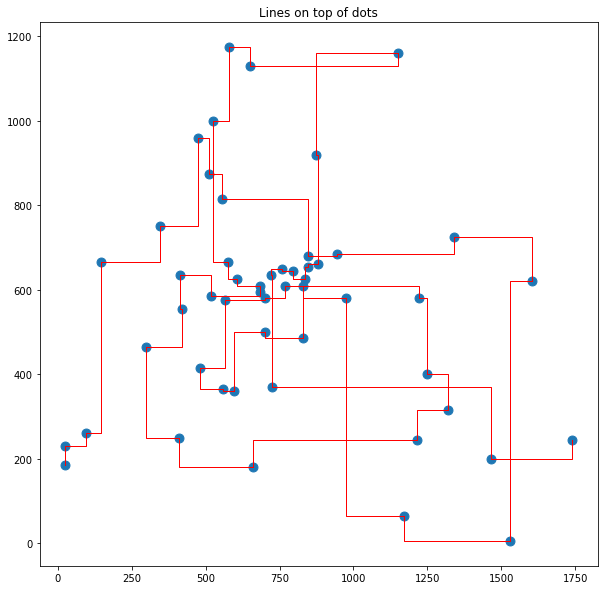

In [478]:
inds = hillClimbOpt(data, 50000)
print(dist(data.loc[inds]))
plotData(data.loc[inds])

In [596]:
def simulatedAnnealingOpt(data, itercount = 10000):
    start_temp = 100
    min_temp = 0.01
    t = start_temp
    best_dist = dist(data)
    cur_ind = data.index.values.copy()
    best_ind = cur_ind
    dlen = len(cur_data)
    for i in range(1,itercount):
        t = start_temp - (start_temp - min_temp)*i/itercount
        if(i%10000==0):
            print(f"{i/itercount*100}%")
        cur_ind = Mutate(best_ind)
        cdist = dist(data.loc[cur_ind])
        delta_e = cdist - best_dist
        if(delta_e < 0):
            best_ind = cur_ind.copy()
            best_dist = cdist
        elif(random.random() < np.exp(-delta_e/t)):
            best_ind = cur_ind.copy()
            best_dist = cdist
        if(t<min_temp):
            break
    return best_ind

20.0%
40.0%
60.0%
80.0%
10335


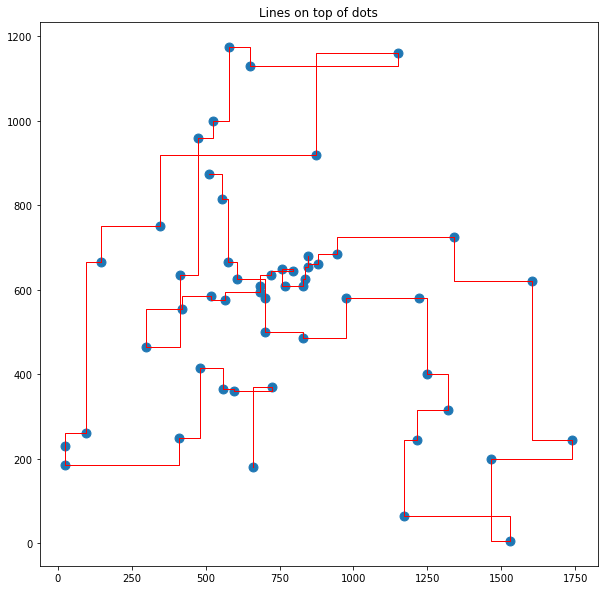

In [476]:
sa_inds = simulatedAnnealingOpt(data, 50000)
print(dist(data.loc[sa_inds]))
plotData(data.loc[sa_inds])

In [636]:
def Crossover(inds1, inds2):
    from_point = random.randint(0,len(inds1)-2)
    to_point = random.randint(from_point,len(inds1)-1)
    child = np.zeros(len(inds1)) 
    child[from_point:to_point] = inds1[from_point:to_point]
    fill_ind = 0
    i = 0
    for ind in inds2:
        i+=1
        if(ind not in child[from_point:to_point]):
            if(fill_ind >= from_point and fill_ind <= to_point):
                fill_ind = to_point
            child[fill_ind] = ind
            fill_ind+=1

    return child


In [700]:
def GeneticOpt(population_size = 20, iter_count = 200, mutation_p = 0.02):

    population = []
    for i in range(0, population_size):
        population.append(np.random.permutation(data.index.values))
        

    for i in range(0, iter_count):
        dists = [1/dist(data.loc[x]) for x in population]
        p = dists/sum(dists)
        parent1, parent2 = (random.choices(population, p, k = 2))
        child = Crossover(parent1, parent2)
        if(random.random() < mutation_p):
            dlen = len(child)
            rand1 = random.randint(0, dlen - 1)
            rand2 = random.randint(0, dlen - 1)
            child[rand1], child[rand2] = child[rand2], child[rand1]

        remove_choice = random.choice(range(0,len(dists)))
        
        population.pop(remove_choice)

        population.append(child)


        #population.append(Crossover(parent1, parent2))
        

    return [dist(data.loc[x]) for x in population]



    #for i in range(0, iter_count):
go_inds = GeneticOpt()

In [701]:
go_inds

[36825,
 36055,
 36965,
 36675,
 36585,
 35235,
 38285,
 38885,
 38165,
 38885,
 38155,
 38585,
 37895,
 38115,
 37195,
 37415,
 35685,
 36585,
 35165,
 38255]